In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from ripser import ripser
from persim import plot_diagrams

In [2]:
from data_cube import DataCube

In [3]:
dc = DataCube(subjects=["10", "20"],
              gestures="all",
              channels=["2", "4", "5", "6", "8"],
              data_grp="parsed")
dc.load_data()

In [4]:
test_sig = dc.data_set["10"]["5_0_1"]

In [5]:
# Setup the sliding window code
def getSlidingWindow(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) # The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) # Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        # Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        # Do spline interpolation to fill in this window, and place
        # it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

In [6]:
# Step 1: Setup the signal
t = test_sig[:, 0]
x = test_sig[:, 1]
N = t.size

In [7]:
# Step 2: Do a sliding window embedding
dim = 50
Tau = 10
dT = 0.5
X = getSlidingWindow(x, dim, Tau, dT)
extent = Tau*dim

In [8]:
# Step 3: Do Rips Filtration
PDs = ripser(X, maxdim=1)['dgms']
I = PDs[1]

In [9]:
# Step 4: Perform PCA down to 2D for visualization
pca = PCA(n_components = 2)
Y = pca.fit_transform(X)
eigs = pca.explained_variance_

<IPython.core.display.Javascript object>


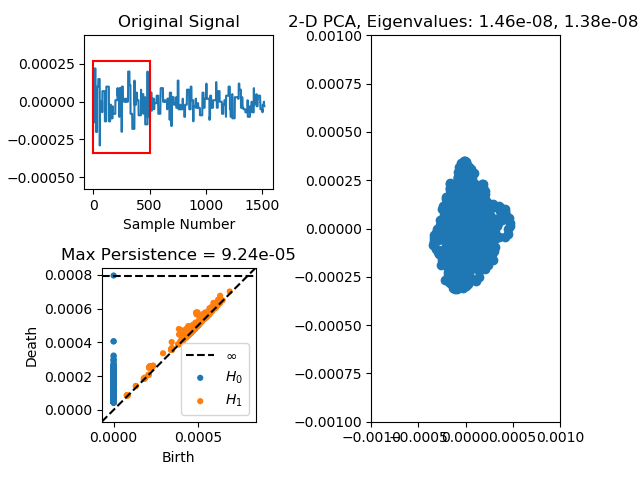

In [10]:
# Step 5: Plot original signal, 2-D projection, and the persistence diagram
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0,0])
ax.plot(x)
ax.set_ylim((2*min(x), 2*max(x)))
ax.set_title("Original Signal")
ax.set_xlabel("Sample Number")
yr = np.max(x)-np.min(x)
yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
ax.plot([extent, extent], yr, 'r')
ax.plot([0, 0], yr, 'r')     
ax.plot([0, extent], [yr[0]]*2, 'r')
ax.plot([0, extent], [yr[1]]*2, 'r')

ax2 = plt.subplot(gs[1,0])
plot_diagrams(PDs)
plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))
    
ax3 = plt.subplot(gs[:,1])
ax3.scatter(Y[:, 0], Y[:, 1])
ax3.set_ylim((-0.001, 0.001))
ax3.set_xlim((-0.001, 0.001))
#plt.axis('equal')
plt.title("2-D PCA, Eigenvalues: %.3g, %.3g "%(eigs[0],eigs[1]))
    
plt.tight_layout()